In [8]:
import numpy as np
from matplotlib import pyplot as plt

import os
import helper as hp
from configparser import ConfigParser

from ppo_refinement import PPORefinement


In [9]:
reward_flag = 0
lambda_partition = -2.5

In [10]:
def _get_lambda_max(p_tensor_single):
    # Convert tensor to NumPy
    p_numpy = p_tensor_single.detach().cpu().numpy()

    # Determine size n from length = n(n+1)/2
    L = p_numpy.shape[0]
    # Solve n(n+1)/2 = L
    n = int((np.sqrt(8 * L + 1) - 1) / 2)
    assert n * (n + 1) // 2 == L, f"Input length {L} is not valid for any symmetric n x n matrix."

    # Fill upper triangular matrix
    A = np.zeros((n, n))
    idx = 0
    for i in range(n):
        for j in range(i, n):  # Only upper triangle including diagonal
            A[i, j] = p_numpy[idx]
            A[j, i] = p_numpy[idx]  # Mirror to lower triangle
            idx += 1

    # Compute eigenvalues
    eigvals = np.linalg.eigvals(A)

    # Sort by real part descending
    eigvals_sorted = sorted(eigvals, key=lambda x: x.real, reverse=True)

    return eigvals_sorted

def compute_reward(p_tensor_single, n_consider=10):
    lambdas_val = _get_lambda_max(p_tensor_single)

    if reward_flag == 0:
        lambda_max_val = lambdas_val[0]
        penalty = np.maximum(0, lambda_max_val)
        if lambda_max_val > 100:
            lambda_max_val = 100
        r = 1.0 / (1.0 + np.exp(lambda_max_val - lambda_partition))
        r -= penalty
    else:
        considered_avg = sum(lambdas_val[:n_consider]) / n_consider
        r = np.exp(-0.1 * considered_avg) / 2
    # TODO: Right now, we are not using the Incidence part of the reward.

    return r

In [13]:
print('--- Begin PPO refinement strategy')

configs = ConfigParser()
configs.read('configfile.ini')
output_path = configs['PATHS']['output_path']
this_savepath = f'output/ppo-refinement/ppo_sandbox/' 
os.makedirs(this_savepath, exist_ok=True)

ppo_agent = PPORefinement(
    param_dim=10,
    noise_dim=10,
    reward_function=compute_reward,
    min_x_bounds=-10,
    max_x_bounds=10,
    ppo_epochs=10,
    T_horizon=100,
    actor_lr=1e-5,
    critic_lr=5e-5,
    n_trajectories=8,
)

trained_actor, rewards = ppo_agent.train(num_training_iterations=1000, output_path=this_savepath)

print(f"PPO training finished. Rewards log saved to {this_savepath}")


--- Begin PPO refinement strategy
Training on cpu. 8 trajectories per update.
Iteration 1/1000, Avg Batch Final Reward: -17.5544
Iteration 2/1000, Avg Batch Final Reward: -16.8138
Iteration 3/1000, Avg Batch Final Reward: -18.3075
Iteration 4/1000, Avg Batch Final Reward: -14.1850
Iteration 5/1000, Avg Batch Final Reward: -14.9761
Iteration 6/1000, Avg Batch Final Reward: -14.7892
Iteration 7/1000, Avg Batch Final Reward: -14.9824
Iteration 8/1000, Avg Batch Final Reward: -14.7892
Iteration 9/1000, Avg Batch Final Reward: -15.2364
Iteration 10/1000, Avg Batch Final Reward: -16.6353
Iteration 11/1000, Avg Batch Final Reward: -18.1714
Iteration 12/1000, Avg Batch Final Reward: -18.6445
Iteration 13/1000, Avg Batch Final Reward: -16.9697
Iteration 14/1000, Avg Batch Final Reward: -15.1228
Iteration 15/1000, Avg Batch Final Reward: -14.0203
Iteration 16/1000, Avg Batch Final Reward: -16.2829
Iteration 17/1000, Avg Batch Final Reward: -19.4728
Iteration 18/1000, Avg Batch Final Reward: -15.

Text(0.5, 1.0, 'PPO Training Rewards')

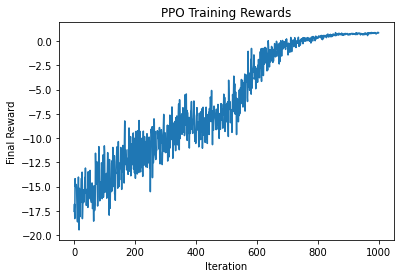

In [16]:
plt.plot(rewards)
plt.xlabel('Iteration')
plt.ylabel('Final Reward')
plt.title('PPO Training Rewards')

In [17]:
import torch
from torch.distributions import Normal

def evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50):
    T_HORIZON = ppo_agent.T_horizon
    NOISE_DIM = ppo_agent.noise_dim
    N_TRIALS = num_trials
    incidence = 0
    for _ in range(N_TRIALS):
        current_params_in_state = ppo_agent._initialize_current_params_for_state().clone()
        generated_sequence = []
        for _ in range(T_HORIZON):
            noise = torch.randn(NOISE_DIM, device=ppo_agent.device)
            state_1d = torch.cat((noise, current_params_in_state.detach()), dim=0)
            state_batch = state_1d.unsqueeze(0)
            with torch.no_grad():
                mu_raw, log_std_raw = trained_actor(state_batch)
                # For generation, you might want to take the mean (mu_raw) or sample
                # action_raw = mu_raw # Deterministic generation
                action_raw = Normal(mu_raw, torch.exp(log_std_raw)).sample() # Stochastic generation
            
            ode_params = ppo_agent._transform_to_bounded(action_raw)
            current_params_in_state = ode_params.squeeze(0)
            generated_sequence.append(current_params_in_state.cpu().numpy())

        final_generated_params = generated_sequence[-1]
        final_reward_eval = compute_reward(torch.tensor(final_generated_params, device=ppo_agent.device))
        lambda_max = _get_lambda_max(torch.tensor(final_generated_params, device=ppo_agent.device))[0]
        if lambda_max < -2.5:
            incidence += 1
        print(f"Final lambda_max: {lambda_max:.4f}")
        print(f"Final reward: {final_reward_eval:.4f}")
    print(f"Incidence over {N_TRIALS} trials: {incidence}/{N_TRIALS} = {incidence/N_TRIALS:.2f}")

In [19]:
evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50)

Final lambda_max: -5.1566
Final reward: 0.9344
Final lambda_max: -4.9405
Final reward: 0.9199
Final lambda_max: -5.2201
Final reward: 0.9382
Final lambda_max: -4.3001
Final reward: 0.8582
Final lambda_max: -4.5017
Final reward: 0.8810
Final lambda_max: -4.4970
Final reward: 0.8805
Final lambda_max: -4.3984
Final reward: 0.8697
Final lambda_max: -6.2478
Final reward: 0.9770
Final lambda_max: -4.7194
Final reward: 0.9020
Final lambda_max: -4.1272
Final reward: 0.8358
Final lambda_max: -4.4326
Final reward: 0.8735
Final lambda_max: -4.5434
Final reward: 0.8853
Final lambda_max: -5.2620
Final reward: 0.9406
Final lambda_max: -3.6996
Final reward: 0.7685
Final lambda_max: -4.6027
Final reward: 0.8912
Final lambda_max: -5.2391
Final reward: 0.9393
Final lambda_max: -4.3966
Final reward: 0.8695
Final lambda_max: -4.1447
Final reward: 0.8382
Final lambda_max: -4.4514
Final reward: 0.8756
Final lambda_max: -5.6531
Final reward: 0.9590
Final lambda_max: -5.5531
Final reward: 0.9549
Final lambda_

In [15]:
n = 5
eigenvalues = np.random.uniform(-10, -2.5, size=n)
random_matrix = np.random.randn(n, n)
Q, _ = np.linalg.qr(random_matrix)

# Step 3: Construct symmetric matrix A
Lambda = np.diag(eigenvalues)
A = Q @ Lambda @ Q.T